# Discover Symmetry of Kepler in 2D (Training)

## Import packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.integrate import odeint

In [2]:
torch.manual_seed(8407)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Play with Data

* Data: $(x,y,v_x,v_y)$


* Hamiltonian:
    $$H = \frac{p^2}{2m} - \frac{GMm}{r}$$
    

* Hamilton's Equation of motion (assume $m=1$):

    \begin{align}
    \dot{x} &= \partial_{p_x}H = p_x = v_x \\
    \dot{v_x} &= -\partial_x H = -\frac{GM}{r^3}x \\
    \dot{y} &= \partial_{p_y}H = p_y = v_y \\
    \dot{v_y} &= -\partial_y H = -\frac{GM}{r^3}y
    \end{align}

In [4]:
G = 1
M = 1

In [5]:
def eom(z, t):
    x, y, vx, vy = z
    dxdt = vx
    dydt = vy
    dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
    dvydt = - G * M / (x**2 + y**2)**(3/2) * y
    return [dxdt, dydt, dvxdt, dvydt]

In [6]:
z0 = [1.3, 1.9, -0.23, 0.17]
print(z0)
t = torch.linspace(0, 10, 10000)

[1.3, 1.9, -0.23, 0.17]


In [7]:
z = odeint(eom, z0, t)

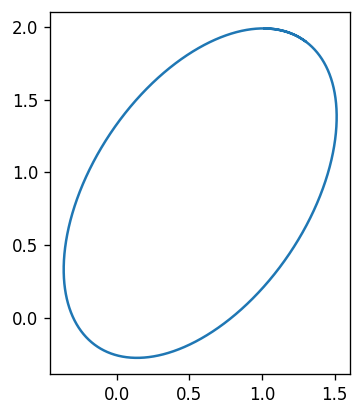

In [8]:
plt.figure(dpi=120)
plt.plot(z[:,0], z[:,1])
ax = plt.gca()
ax.set_aspect("equal")

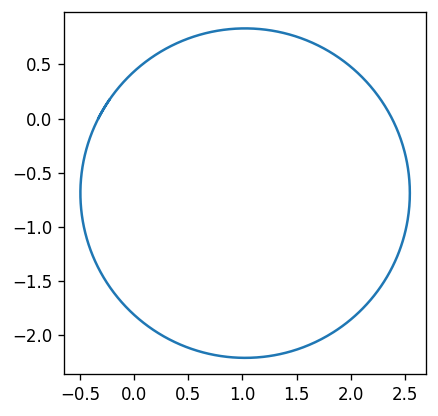

In [9]:
plt.figure(dpi=120)
plt.plot(z[:,2], z[:,3])
ax = plt.gca()
ax.set_aspect("equal")

In [10]:
X = torch.Tensor(z).float()
# Positive Pair
idx = torch.randperm(len(t))
X_p = X[idx, :]

# Negative Pair - 1. x
idx_x = torch.randperm(len(t))
X_x = X.clone()
X_x[:,0] = X_x[idx_x, 0]

# Negative Pair - 2. y
idx_y = torch.randperm(len(t))
X_y = X.clone()
X_y[:,1] = X_y[idx_y, 1]

# Negative Pair - 3. vx
idx_vx = torch.randperm(len(t))
X_vx = X.clone()
X_vx[:,2] = X_vx[idx_vx, 2]

# Negative Pair - 4. vy
idx_vy = torch.randperm(len(t))
X_vy = X.clone()
X_vy[:,3] = X_y[idx_vy, 3]

# Mix Negative Pair
X_n_tot = torch.stack([X_x, X_y, X_vx, X_vy], dim=2)
idx_neg = torch.randint(4, (len(t),))
X_n = torch.Tensor(X.shape[0], X.shape[1])
for i in range(X.shape[0]):
    X_n[i, :] = X_n_tot[i, :, idx_neg[i]]

In [11]:
X

tensor([[ 1.3000,  1.9000, -0.2300,  0.1700],
        [ 1.2998,  1.9002, -0.2301,  0.1698],
        [ 1.2995,  1.9003, -0.2302,  0.1697],
        ...,
        [ 1.0204,  1.9893, -0.3280,  0.0055],
        [ 1.0201,  1.9893, -0.3281,  0.0053],
        [ 1.0198,  1.9894, -0.3281,  0.0051]])

In [12]:
X_p

tensor([[ 0.8669,  1.9738, -0.3672, -0.0771],
        [ 1.2616,  1.9253, -0.2469,  0.1448],
        [ 0.6707, -0.0891,  1.2244,  0.8183],
        ...,
        [ 1.3526,  1.8542, -0.2035,  0.2075],
        [ 0.7525,  1.9415, -0.3928, -0.1390],
        [ 1.2767,  0.5811,  0.3947,  0.6950]])

In [13]:
X_n

tensor([[ 1.3000,  1.9000, -0.2300,  0.4678],
        [ 1.2998,  1.9311, -0.2301,  0.1698],
        [ 1.2995,  1.9003, -0.3856,  0.1697],
        ...,
        [ 1.0204,  1.9893, -0.0262,  0.0055],
        [-0.1248,  1.9893, -0.3281,  0.0053],
        [ 1.0198,  1.9894,  1.7093,  0.0051]])

## Implement Dataset

In [14]:
class Kepler2D(Dataset):
    def __init__(self, t, z0, G=1, M=1):
        tmin, tmax, tnum = t
        
        def eom(z, t):
            x, y, vx, vy = z
            dxdt = vx
            dydt = vy
            dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
            dvydt = - G * M / (x**2 + y**2)**(3/2) * y
            return [dxdt, dydt, dvxdt, dvydt]
        
        t = torch.linspace(tmin, tmax, tnum)
        X = torch.Tensor(odeint(eom, z0, t)).float()
        
        # Positive Pair
        idx = torch.randperm(len(t))
        X_p = X[idx, :]
        
        # Negative Pair - 1. x
        idx_x = torch.randperm(len(t))
        X_x = X.clone()
        X_x[:,0] = X_x[idx_x, 0]
        
        # Negative Pair - 2. y
        idx_y = torch.randperm(len(t))
        X_y = X.clone()
        X_y[:,1] = X_y[idx_y, 1]
        
        # Negative Pair - 3. vx
        idx_vx = torch.randperm(len(t))
        X_vx = X.clone()
        X_vx[:,2] = X_vx[idx_vx, 2]
        
        # Negative Pair - 4. vy
        idx_vy = torch.randperm(len(t))
        X_vy = X.clone()
        X_vy[:,3] = X_y[idx_vy, 3]
        
        # Mix Negative Pair
        X_n_tot = torch.stack([X_x, X_y, X_vx, X_vy], dim=2)
        idx_neg = torch.randint(4, (len(t),))
        X_n = torch.Tensor(X.shape[0], X.shape[1]).float()
        for i in range(X.shape[0]):
            X_n[i, :] = X_n_tot[i, :, idx_neg[i]]
            
        self.X = X
        self.X_p = X_p
        self.X_n = X_n
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_p = torch.Tensor(self.X_p[idx])
        x_n = torch.Tensor(self.X_n[idx])
        return x, x_p, x_n

In [15]:
t_train = (0, 10, 50000)
t_valid = (0, 10, 5000)

In [16]:
train_dataset = Kepler2D(t_train, z0)
valid_dataset = Kepler2D(t_valid, z0)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

In [17]:
for _, samples in enumerate(train_dataloader):
    x, x_p, x_n = samples
    print(x)
    print()
    print(x_p)
    print()
    print(x_n)
    break

tensor([[ 1.2244,  1.9448, -0.2619,  0.1215],
        [ 1.3150,  1.8884, -0.2229,  0.1803],
        [-0.0682,  1.2274, -0.4931, -0.7725],
        ...,
        [ 0.9874,  1.9890, -0.3370, -0.0124],
        [ 1.1387,  1.9746, -0.2923,  0.0710],
        [ 1.4388,  1.7335, -0.1452,  0.2824]])

tensor([[ 0.0938,  1.4489, -0.4923, -0.5900],
        [ 1.0878,  1.9843, -0.3084,  0.0424],
        [ 1.4343,  0.9315,  0.1965,  0.5864],
        ...,
        [ 1.2201,  0.4872,  0.4607,  0.7232],
        [ 1.5042,  1.2294,  0.0625,  0.4885],
        [ 1.1223,  1.9783, -0.2976,  0.0617]])

tensor([[ 1.2244,  1.9448, -0.2619, -1.9036],
        [ 1.1404,  1.8884, -0.2229,  0.1803],
        [-0.0682,  1.2274,  0.4454, -0.7725],
        ...,
        [ 0.9874,  1.9890, -0.3070, -0.0124],
        [ 1.1387,  1.9746, -0.4939,  0.0710],
        [ 1.4388,  1.9075, -0.1452,  0.2824]])


## Implement Siamese Network

In [18]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.Softplus()
        )

    def forward(self, x, x_p, x_n):
        out1 = self.linear_relu(x)
        out2 = self.linear_relu(x_p)
        out3 = self.linear_relu(x_n)
        return out1, out2, out3

In [19]:
net = SNN()
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)


In [20]:
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [21]:
def train(net, dataloaders_dict, criterion, optimizer, num_epochs, dist=1):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, X_n = samples
                X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    out1, out2, out3 = net(X, X_p, X_n)
                    loss = criterion(out1, out2, out3)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() + X.shape[0]
                    epoch_corr += torch.count_nonzero(torch.abs(out1 - out2) <= torch.abs(out1 - out3)).item()
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_acc = epoch_corr / len(data.dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation Acc : {epoch_acc:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [22]:
train_loss, val_loss = train(net, dataloaders_dict, criterion, optimizer, 500, 0.2)

 22%|██▏       | 22/100 [00:00<00:00, 217.97it/s]

Epoch 1/500
----------------------


 22%|██▏       | 22/100 [00:00<00:00, 218.85it/s]

 Validation Loss: 1.000532
 Validation Acc : 0.962000
 Learning Rate  : 0.010000

Epoch 2/500
----------------------


 22%|██▏       | 22/100 [00:00<00:00, 217.34it/s]

 Validation Loss: 1.000382
 Validation Acc : 0.968600
 Learning Rate  : 0.010000

Epoch 3/500
----------------------


 22%|██▏       | 22/100 [00:00<00:00, 217.08it/s]

 Validation Loss: 1.000332
 Validation Acc : 0.964200
 Learning Rate  : 0.010000

Epoch 4/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 199.36it/s]

 Validation Loss: 1.000254
 Validation Acc : 0.994200
 Learning Rate  : 0.010000

Epoch 5/500
----------------------


 22%|██▏       | 22/100 [00:00<00:00, 215.48it/s]

 Validation Loss: 1.000243
 Validation Acc : 0.984200
 Learning Rate  : 0.010000

Epoch 6/500
----------------------


 16%|█▌        | 16/100 [00:00<00:00, 153.66it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.978200
 Learning Rate  : 0.010000

Epoch 7/500
----------------------


 18%|█▊        | 18/100 [00:00<00:00, 172.08it/s]

 Validation Loss: 1.000217
 Validation Acc : 0.982000
 Learning Rate  : 0.010000

Epoch 8/500
----------------------


 21%|██        | 21/100 [00:00<00:00, 206.92it/s]

 Validation Loss: 1.000190
 Validation Acc : 0.991200
 Learning Rate  : 0.010000

Epoch 9/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 198.10it/s]

 Validation Loss: 1.000186
 Validation Acc : 0.986400
 Learning Rate  : 0.010000

Epoch 10/500
----------------------


 17%|█▋        | 17/100 [00:00<00:00, 167.52it/s]

 Validation Loss: 1.000197
 Validation Acc : 0.976200
 Learning Rate  : 0.001000

Epoch 11/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 193.82it/s]

 Validation Loss: 1.000160
 Validation Acc : 0.997000
 Learning Rate  : 0.001000

Epoch 12/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 193.81it/s]

 Validation Loss: 1.000158
 Validation Acc : 0.997800
 Learning Rate  : 0.001000

Epoch 13/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 191.05it/s]

 Validation Loss: 1.000158
 Validation Acc : 0.997600
 Learning Rate  : 0.001000

Epoch 14/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 193.93it/s]

 Validation Loss: 1.000157
 Validation Acc : 0.998000
 Learning Rate  : 0.001000

Epoch 15/500
----------------------


 16%|█▌        | 16/100 [00:00<00:00, 159.96it/s]

 Validation Loss: 1.000156
 Validation Acc : 0.997800
 Learning Rate  : 0.001000

Epoch 16/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 196.23it/s]

 Validation Loss: 1.000155
 Validation Acc : 0.997800
 Learning Rate  : 0.000100

Epoch 17/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 189.10it/s]

 Validation Loss: 1.000154
 Validation Acc : 0.998200
 Learning Rate  : 0.000100

Epoch 18/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 195.48it/s]

 Validation Loss: 1.000154
 Validation Acc : 0.998600
 Learning Rate  : 0.000100

Epoch 19/500
----------------------


 22%|██▏       | 22/100 [00:00<00:00, 213.73it/s]

 Validation Loss: 1.000154
 Validation Acc : 0.998400
 Learning Rate  : 0.000100

Epoch 20/500
----------------------


 21%|██        | 21/100 [00:00<00:00, 205.28it/s]

 Validation Loss: 1.000154
 Validation Acc : 0.998400
 Learning Rate  : 0.000100

Epoch 21/500
----------------------


 21%|██        | 21/100 [00:00<00:00, 201.17it/s]

 Validation Loss: 1.000154
 Validation Acc : 0.998600
 Learning Rate  : 0.000100

Epoch 22/500
----------------------


 17%|█▋        | 17/100 [00:00<00:00, 168.41it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998600
 Learning Rate  : 0.000100

Epoch 23/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 182.05it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.997800
 Learning Rate  : 0.000100

Epoch 24/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 187.35it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000010

Epoch 25/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 145.18it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000010

Epoch 26/500
----------------------


 20%|██        | 20/100 [00:00<00:00, 191.44it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000010

Epoch 27/500
----------------------


 17%|█▋        | 17/100 [00:00<00:00, 167.92it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000010

Epoch 28/500
----------------------


  9%|▉         | 9/100 [00:00<00:01, 87.25it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000010

Epoch 29/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 184.79it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000010

Epoch 30/500
----------------------


 18%|█▊        | 18/100 [00:00<00:00, 179.31it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000001

Epoch 31/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 99.76it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000001

Epoch 32/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 186.12it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998200
 Learning Rate  : 0.000001

Epoch 33/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 183.08it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000001

Epoch 34/500
----------------------


 18%|█▊        | 18/100 [00:00<00:00, 129.90it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000001

Epoch 35/500
----------------------


 19%|█▉        | 19/100 [00:00<00:00, 184.54it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000001

Epoch 36/500
----------------------


100%|██████████| 10/10 [00:00<00:00, 210.40it/s]

 Validation Loss: 1.000153
 Validation Acc : 0.998400
 Learning Rate  : 0.000000



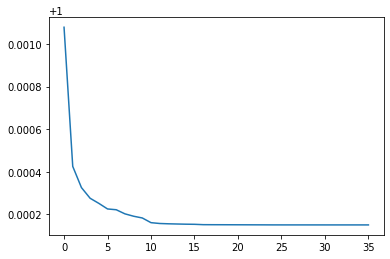

In [23]:
plt.plot(train_loss)
plt.show()

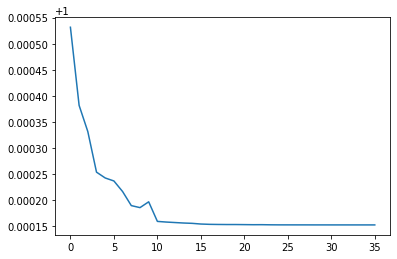

In [24]:
plt.plot(val_loss)
plt.show()

In [25]:
anc, pos, neg = train_dataset[0:10]

In [26]:
with torch.no_grad():
    a, b, c = net(anc, pos, neg)
    res1 = torch.column_stack([a, b, c])
    print(res1)

tensor([[1.4137e+01, 1.4140e+01, 1.5200e+01],
        [1.4137e+01, 1.4144e+01, 4.6432e+00],
        [1.4137e+01, 1.4143e+01, 8.7198e-01],
        [1.4137e+01, 1.4137e+01, 1.2761e+01],
        [1.4137e+01, 1.4136e+01, 1.7663e+01],
        [1.4137e+01, 1.4145e+01, 1.4592e+01],
        [1.4137e+01, 1.4143e+01, 1.7301e+01],
        [1.4137e+01, 1.4145e+01, 9.9165e-12],
        [1.4137e+01, 1.4145e+01, 1.8849e+01],
        [1.4137e+01, 1.4146e+01, 1.4170e+01]])


In [27]:
torch.save(net, "model/snn_kepl2d_trip_02.pt")